<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de Contagios por Covid-19



### Cargar Base de Datos


In [202]:
!pip install wget 
import pandas as pd
import numpy as np 
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

#wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3


### Dividir el conjunto de Datos


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi = 0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    #pi += 1
    #pf += 1
    #print(serie.shape[0])
    while pf+1 <   serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf += 1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [204]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)


prueba = serie[-5:-1]
prueba1 = np.append(prueba, serie[-1])
prueba1

array([6507, 7006, 7285, 7668, 7973], dtype=object)

In [160]:
data.iloc[82]

Province/State         NaN
Country/Region    Colombia
Lat                 4.5709
Long              -74.2973
1/22/20                  0
                    ...   
4/30/20               6507
5/1/20                7006
5/2/20                7285
5/3/20                7668
5/4/20                7973
Name: 82, Length: 108, dtype: object

In [161]:
X[-1]

array([5949, 6207, 6507, 7006, 7285], dtype=object)

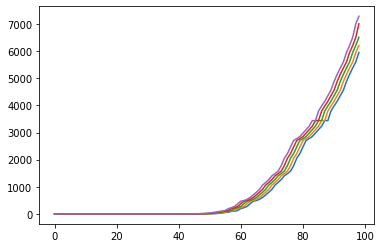

In [162]:
plt.plot(X)

### Análisis Exploratorio PCA

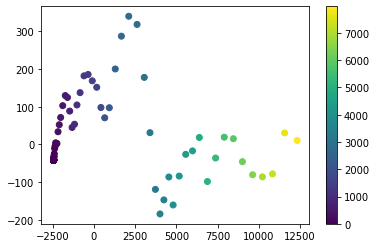

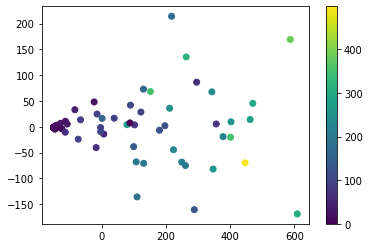

In [163]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Análisis Exploratorio TSNE

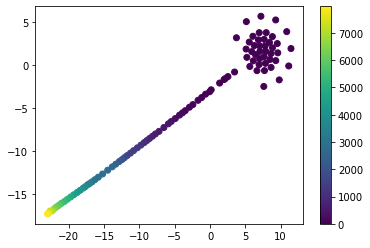

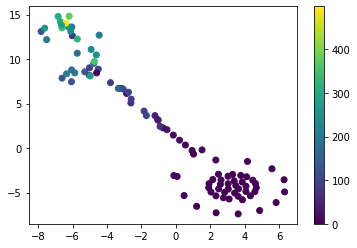

In [164]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

### Función Validación Cruzada Anidada


In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

def V_Cruzada_Anidada(X_data,Y_data,steps,parameters):
  
  Niter = 10                           #numero particiones outter loop nested cross-validation
  msev = np.zeros((Niter,len(steps)))  #arreglo para guardar acierto
  best_estimators = []                 #mejor metodo por iteracion
  ###clave del funcionamiento
  best_hyperpar = []                   #mejor metodo por iteracion 
            

  for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3) # xtrain 60, xtest 26

      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)

          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          #print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          #print(best_hyperpar)
          #print('mse:',msev[j,r])

          savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_hyperpar,
              } 
          #dump(savedata,'covid19_1.joblib')

  return best_estimators,best_hyperpar,msev

#### Validación Cruzada Anidada LR:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRegression



In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  LinearRegression())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  LinearRegression())]
          ]

parameters = [
                {
                 },
                {
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_LR = ['NorSC-LR','NorSC-PCA-LR']

B_Model_LR, B_Hiperpara_LR, MAE_LR = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 2/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concu

it 3/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 4/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s f

it 5/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 6/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   6 tasks      |

it 7/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 8/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0049s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 

it 9/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 10/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too f

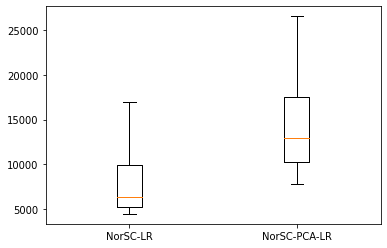

In [167]:
plt.boxplot(MAE_LR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_LR)
plt.show()

In [168]:
MAE_LR

array([[ 9456.20023488, 16386.75911594],
       [16931.44850692, 17909.56827714],
       [ 4518.56180313,  7822.94778641],
       [10022.99655237, 12201.1721155 ],
       [ 5026.13020781, 11592.46874428],
       [11423.20922861, 26562.55073722],
       [ 7026.16186312, 25323.96773611],
       [ 5641.80319988,  9850.89158811],
       [ 5612.50692605, 13739.5421662 ],
       [ 4450.90038171,  7878.1629941 ]])

In [169]:
B_Hiperpara_LR

[{},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5}]

In [170]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', LinearRegression())]

Mod_SC_LR = Pipeline(steps = steps)
Mod_SC_LR.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [171]:
from datetime import date
Xn = prueba1

Xn = Xn.reshape(1,-1)
Pre_SC_LR = Mod_SC_LR.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRegression: [[8772.70897312]]


#### Validación Cruzada Anidada Ridge:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRidge


In [172]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Ridge( ))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Ridge())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 },
                {'rep__n_components':[0.5,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 }
               ]

label_model_R = ['NorSC-R','NorSC-PCA-R']

B_Model_R, B_Hiperpara_R, MAE_R = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0065s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0065s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0572s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0425s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0069s.) Settin

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0868s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0722s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 155 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 173 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0063s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0063s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s


it 2/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0531s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  63 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0329s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0832s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1660s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


it 3/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0309s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0785s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Don

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0617s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1416s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks  

it 4/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0632s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0751s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0503s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0968s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


it 5/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0363s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0648s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Don

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0766s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1266s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 6/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0704s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0911s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0310s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0839s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1718s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0332s.)

it 7/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0785s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0454s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0709s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1473s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0322s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0838s.)

it 8/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0424s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0806s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1404s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


it 9/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0385s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0667s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Don

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1203s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1220s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 10/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0434s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0624s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0743s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0736s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1592s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


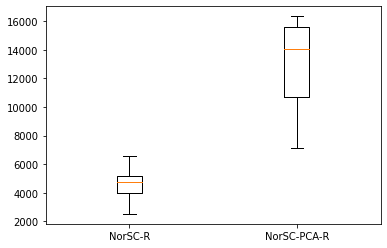

In [173]:
plt.boxplot(MAE_R)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_R)
plt.show()

In [174]:
MAE_R

array([[ 2526.01253026, 11555.32154488],
       [ 3581.34526349,  7163.04829132],
       [ 5063.4602081 , 14350.52256361],
       [ 5040.12981712, 15874.29279446],
       [ 6570.21504234, 15813.36102096],
       [ 4240.29833885, 16336.21669687],
       [ 5778.42523004, 14955.54237403],
       [ 3920.51604897, 10389.25048001],
       [ 5239.740408  , 13710.01398649],
       [ 4498.43128233,  8069.16705659]])

In [175]:
B_Hiperpara_R

[{'reg__alpha': 0.01, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.01, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'sag', 'rep__n_components': 0.5},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'cholesky'},
 {'reg__alpha': 1, 'reg__solver': 'sag', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'svd'},
 {'reg__alpha': 0.01, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.01, 'reg__solver': 'saga', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg

In [176]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.001, solver='lsqr'))]

Mod_SC_R = Pipeline(steps = steps)
Mod_SC_R.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='lsqr', tol=0.001))],
         verbose=False)

In [177]:
Xn = prueba1

Xn = Xn.reshape(1,-1)
Pre_SC_R = Mod_SC_R.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRidge: [[8782.47808003]]


#### Validación Cruzada Anidada Lasso:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearLasso

In [178]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Lasso())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Lasso())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 },
                {'rep__n_components':[0.5,0.75,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 }
               ]

label_model_L = ['NorSC-L','NorSC-PCA-L']

B_Model_L, B_Hiperpara_L, MAE_L = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  11 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205868.12112705683, tolerance: 39323.69048115943
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251164.53198974236, tolerance: 37605.42166376811
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 conc

it 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

it 3/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0404s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0814s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 4/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0208s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132878.27137551073, tolerance: 26377.36448695653
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Para

it 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0459s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1044s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | e

it 6/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0744s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0232s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergence

it 7/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0639s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0528s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s rem

it 8/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1471s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 9/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0217s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254772.34809296633, tolerance: 33159.228220289864
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fa

it 10/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0508s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished


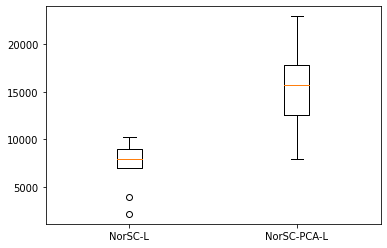

In [179]:
plt.boxplot(MAE_L)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_L)
plt.show()

In [180]:
MAE_L

array([[ 8741.4228154 , 22934.67064491],
       [ 3928.92719431,  7965.93726987],
       [ 7252.42968769, 17407.35093827],
       [ 9738.09160299, 18015.53392185],
       [ 8623.67332272, 11587.17997788],
       [10200.29143711, 14069.6027266 ],
       [ 9020.18471691, 17298.51065606],
       [ 6980.10231189, 17961.02066996],
       [ 2166.92626689, 12390.63240552],
       [ 7023.06662863, 12907.14816249]])

In [181]:
B_Hiperpara_L

[{'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5}]

In [182]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.1))]

Mod_SC_L = Pipeline(steps = steps)
Mod_SC_L.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [183]:
Xn = prueba1

Xn = Xn.reshape(1,-1)
Pre_SC_L = Mod_SC_L.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearLasso: [[8895.84508578]]


#### Validación Cruzada Anidada EN:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearElasticNet

In [184]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  ElasticNet())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  ElasticNet( ))]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100]
                 },
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100],
                  'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_EN = ['NorSC-EN','NorSC-PCA-EN']

B_Model_EN, B_Hiperpara_EN, MAE_EN = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0236s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0485s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1044s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1049s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1643s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_desce

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1360s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1973s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 673 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=

it 2/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0546s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0733s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1863s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298345.19099393586, tolerance: 30101.069794202896
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1289s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1881s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 596 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 673 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 3/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0483s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0629s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1242s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1330s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0784s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 4/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0762s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1108s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239850.82880883807, tolerance: 39089.302220289865
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0972s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0073s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0073s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0467s.) Setting batch_size=8.


it 5/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1412s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1719s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 148 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 228 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254676.10330152576, tolerance: 30466.174576811594
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0855s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1559s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0097s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0341s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 6/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0843s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280563.08602435794, tolerance: 30906.170260869563
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0229s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0277s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0661s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1032s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with

it 7/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1024s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1023s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1054s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193413.24553054865, tolerance: 33457.86470724638
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0532s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0803s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1369s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 680 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with

it 8/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0895s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0795s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1247s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285247.0340738604, tolerance: 24670.430530434787
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1119s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0389s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0719s.) Setting batch_size=8.


it 9/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1440s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1962s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222847.31383308998, tolerance: 29249.64717391305
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0095s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0499s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0780s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1444s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

it 10/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0393s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0892s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1061s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326968.0569368196, tolerance: 36085.90166376811
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation t

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1276s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1294s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished


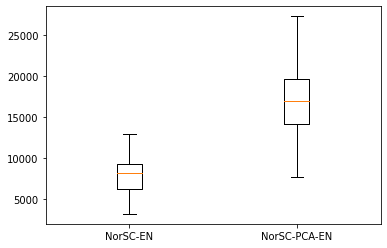

In [185]:
plt.boxplot(MAE_EN)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_EN)
plt.show()

In [186]:
MAE_EN

array([[ 8349.9099288 , 16540.94373906],
       [ 9589.05033498, 18422.17684802],
       [ 8433.9952388 , 20157.12939076],
       [12652.06335061, 27323.06454264],
       [ 6683.77701355, 17463.78559694],
       [ 5719.89025177, 16184.204536  ],
       [12937.38642678,  7735.62429717],
       [ 6029.69667825, 13439.79178107],
       [ 3201.67527976, 10345.39604114],
       [ 8113.61190614, 21527.86987531]])

In [187]:
B_Hiperpara_EN

[{'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.01},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.1},
 {'reg__alpha': 10, 'reg__l1_ratio': 1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio':

In [188]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', ElasticNet(alpha=0.001, l1_ratio=1))]

Mod_SC_EN = Pipeline(steps = steps)
Mod_SC_EN.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216219.2792065452, tolerance: 28753.624628985508
  positive)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [189]:
Xn = prueba1

Xn = Xn.reshape(1,-1)
Pre_SC_EN = Mod_SC_EN.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearElasticNet: [8959.33373139]


#### Validación Cruzada Anidada KR:

- Normalización StandadScalar
- Representación PCA
- Regresor KernelRidge

In [190]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_KR = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

B_Model_KR, B_Hiperpara_KR, MAE_KR = V_Cruzada_Anidada(X,y,steps,parameters)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0446s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1036s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0844s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0092s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0768s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2

it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0496s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1674s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0877s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1355s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 469 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0582s.) Setting batch_size=4.


it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0742s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1160s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1122s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 254 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 501 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0190s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[

it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0722s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0752s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0679s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1212s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0487s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 134 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0568s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1176s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 443 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 471 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    1.9s


it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1949s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0810s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1141s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0579s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1106s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1046s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0681s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0785s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]

it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0894s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1018s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0885s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1110s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 484 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computatio

it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1915s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 126 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0745s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1485s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0097s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0728s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0692s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0538s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 282 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 474 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished


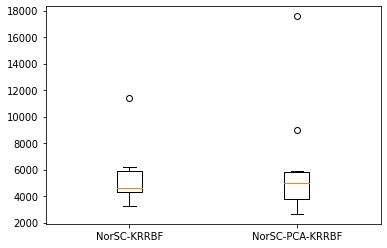

In [191]:
plt.boxplot(MAE_KR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_KR)
plt.show()

In [192]:
val = 100*100
cont = -1
for i in range(MAE_KR.shape[0]):
  for j in range(MAE_KR.shape[1]):
    cont +=1    
    if (val > MAE_KR[i,j]):
      val = MAE_KR[i,j]
      pos = cont

print(pos)
print(val)

5
2649.2068868199112


In [193]:
MAE_KR

array([[11405.19662578, 17570.65985044],
       [ 3246.55627959,  3630.31798338],
       [ 4552.52286422,  2649.20688682],
       [ 3438.51792021,  4364.58176588],
       [ 6188.40410038,  9006.52756168],
       [ 4304.92677545,  3074.31943681],
       [ 6029.64499088,  5586.20300431],
       [ 4336.38725977,  5648.11422849],
       [ 4624.44717017,  5880.58250558],
       [ 5500.08161308,  4348.35200995]])

In [194]:
B_Model_KR[pos]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [195]:
print(B_Hiperpara_KR[pos])
B_Hiperpara_KR

{'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}


[{'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components

In [199]:
steps =  [('scaler', StandardScaler()),
          ('rep', PCA(n_components=0.5)),                         
          ('reg', KernelRidge(alpha=0.001, kernel='rbf', gamma=0.01))]

Mod_SC_PCA_KRrbf = Pipeline(steps = steps)
Mod_SC_PCA_KRrbf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [200]:
Xn = prueba1

Xn = Xn.reshape(1,-1)
Pre_SC_PCA_KRrbf = Mod_SC_PCA_KRrbf.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo KernelRidge_rbf: [[8997.46901051]]


In [201]:
print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRegression: [[8772.70897312]]
Predicción contagios para 2020-05-06 usando un modelo LinearRidge: [[8782.47808003]]
Predicción contagios para 2020-05-06 usando un modelo LinearLasso: [[8895.84508578]]
Predicción contagios para 2020-05-06 usando un modelo LinearElasticNet: [8959.33373139]
Predicción contagios para 2020-05-06 usando un modelo KernelRidge_rbf: [[8997.46901051]]
